# Lendo os dados
---

In [1]:

import pandas as pd
from datetime import datetime

wlcota_df = pd.read_csv(
    "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv")

# Removing some columns
wlcota_columns = wlcota_df.columns.tolist()
rm_columns = ["deaths_per_100k_inhabitants", "totalCases_per_100k_inhabitants", "deathsMS",
              "deaths_by_totalCases", "tests_per_100k_inhabitants", "totalCasesMS", "tests"]
for col in rm_columns:
    wlcota_columns.pop(wlcota_columns.index(col))
wlcota_df = wlcota_df[wlcota_columns]

wlcota_df.head()


epi_week        date country  state   city  newDeaths  deaths  newCases  \
0         9  2020-02-25  Brazil     SP  TOTAL          0       0         1   
1         9  2020-02-25  Brazil  TOTAL  TOTAL          0       0         1   
2         9  2020-02-26  Brazil     SP  TOTAL          0       0         0   
3         9  2020-02-26  Brazil  TOTAL  TOTAL          0       0         0   
4         9  2020-02-27  Brazil     SP  TOTAL          0       0         0   

   totalCases  recovered  suspects  
0           1        NaN       NaN  
1           1        NaN       NaN  
2           1        NaN       NaN  
3           1        NaN       NaN  
4           1        NaN       NaN

In [2]:
import yaml

with open('state_pop.yaml') as file:
    state_pop = yaml.load(file, Loader=yaml.FullLoader)

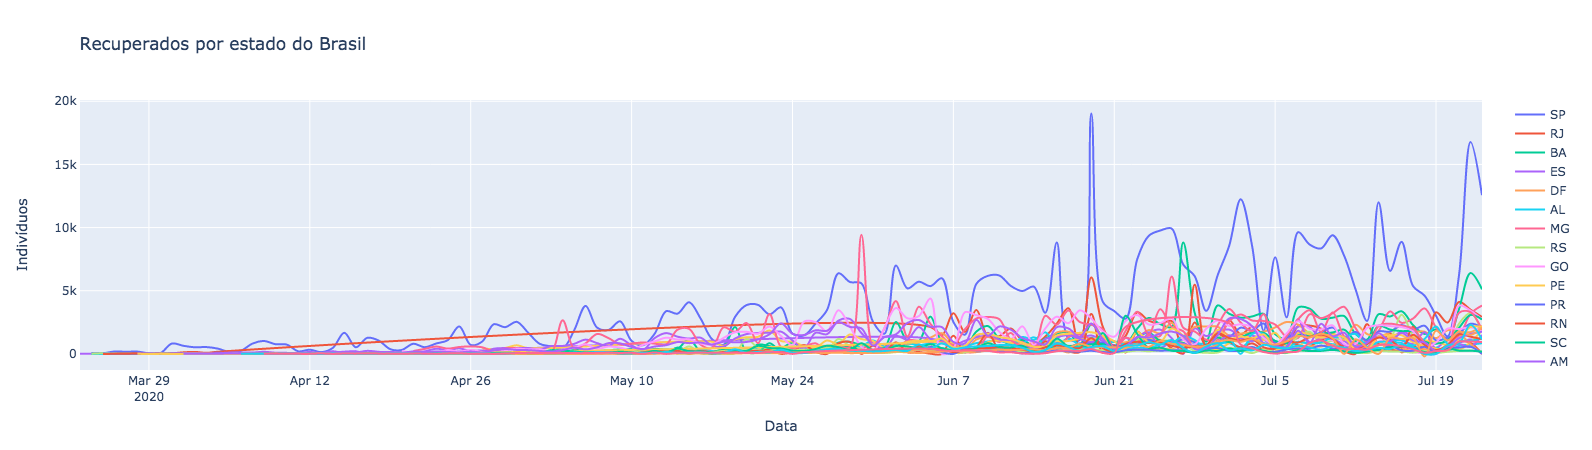

In [3]:
states = wlcota_df["state"].unique().tolist()
states.pop(states.index("TOTAL"))

import plotly.graph_objects as go

fig = go.Figure()
for state in states:
    state_df = wlcota_df.where(wlcota_df["state"]==state).dropna()
    fig.add_trace(go.Scatter(
        name=state,
        x=state_df["date"],
        y=state_df["newCases"],
        mode='lines',
        line_shape='spline'))
    
fig.update_layout(#template='plotly_dark',
                  xaxis_title='Data', yaxis_title='Indivíduos',
                  title_text="Recuperados por estado do Brasil")
fig.show()

# Computing the time variant $\beta(t)$
---

In [4]:
state = "MA"

state_df = wlcota_df.where(wlcota_df["state"] == state).dropna()
state_df.head()

epi_week        date country state   city  newDeaths  deaths  newCases  \
555      14.0  2020-04-01  Brazil    MA  TOTAL        0.0     1.0      19.0   
583      14.0  2020-04-02  Brazil    MA  TOTAL        0.0     1.0      10.0   
611      14.0  2020-04-03  Brazil    MA  TOTAL        0.0     1.0       7.0   
639      14.0  2020-04-04  Brazil    MA  TOTAL        1.0     2.0       8.0   
667      15.0  2020-04-05  Brazil    MA  TOTAL        0.0     2.0      37.0   

     totalCases  recovered  suspects  
555        70.0       12.0     774.0  
583        80.0       12.0     913.0  
611        87.0       12.0     913.0  
639        95.0       12.0     913.0  
667       132.0       12.0     913.0

In [5]:
import numpy as np

pop = state_pop[state]["population"]

dR = state_df["recovered"].diff().dropna().tolist()
dD = state_df["deaths"].diff().dropna().tolist()
dC = state_df["totalCases"].diff().dropna().tolist()

I = [ state_df["totalCases"].iloc[0] ]
for nr, nd, nc in zip(dR,dD,dC):
    I += [ I[-1] + nc - nr - nd ]
R = state_df["recovered"].tolist()
D = state_df["deaths"].tolist()
I, R, D = np.array(I), np.array(R), np.array(D) 
S = pop - I - R - D


### 1 - Interpolate to define the $f(t)$

In [6]:
from PyAstronomy import pyasl
from scipy.interpolate import UnivariateSpline

time = np.linspace(0, len(I)-1, len(I))
f_t = UnivariateSpline(time, I)

# Including some filtering
ff_t = lambda x: pyasl.smooth(f_t(x), 51, "hamming")

time_sim = np.linspace(0, len(I)-1, 10*len(I))

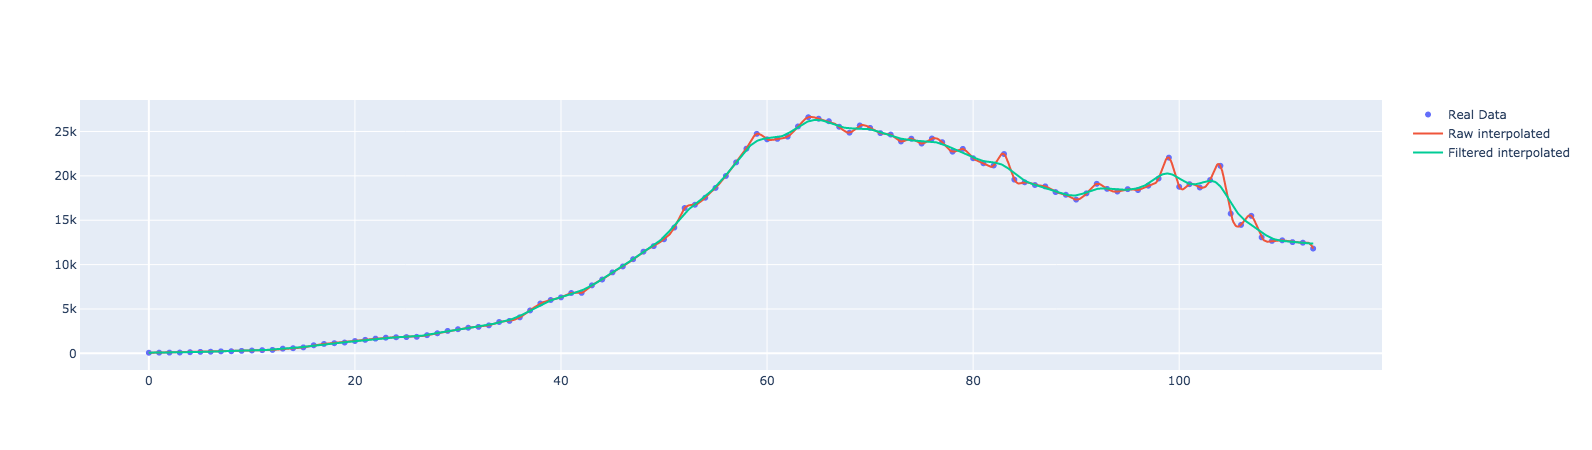

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Real Data",
    x=time, 
    y=I,
    mode="markers"))

fig.add_trace(go.Scatter(
    name="Raw interpolated",
    x=time_sim,
    y=f_t(time_sim)))

fig.add_trace(go.Scatter(
    name="Filtered interpolated",
    x=time_sim,
    y=ff_t(time_sim)))

fig.show()

### 2 - Verifing the condition: $\frac{f'(t)}{f(t)}>-r$ 

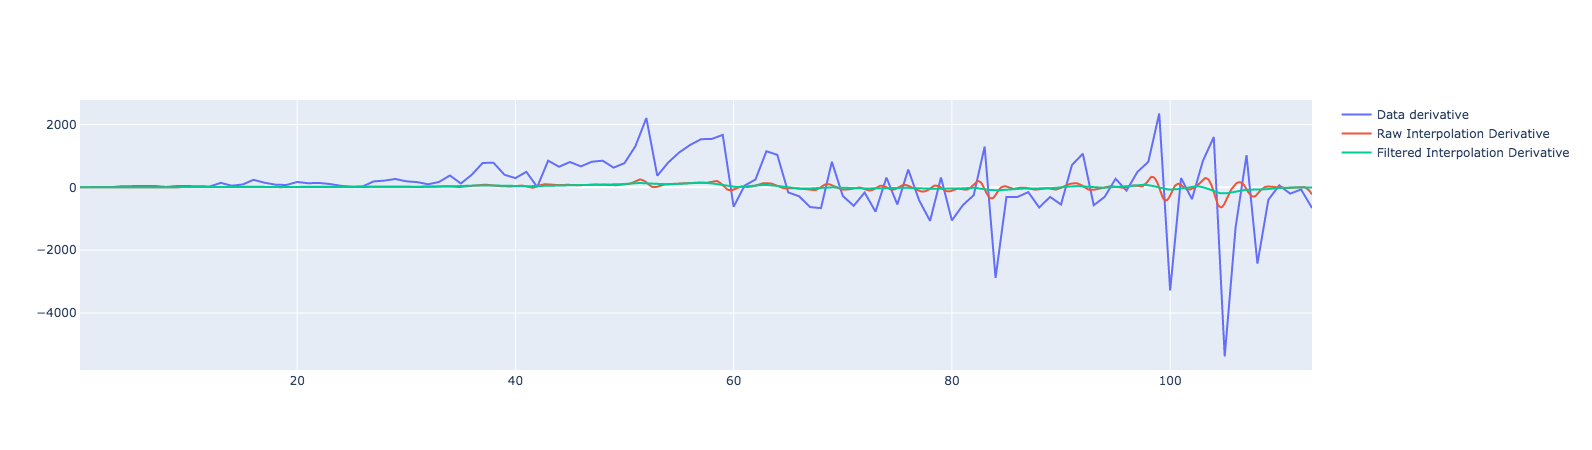

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Data derivative",
    x=time[1:],
    y=np.diff(I)))

fig.add_trace(go.Scatter(
    name="Raw Interpolation Derivative",
    x=time_sim[1:],
    y=np.diff(f_t(time_sim))))

fig.add_trace(go.Scatter(
    name="Filtered Interpolation Derivative",
    x=time_sim[1:],
    y=np.diff(ff_t(time_sim))))

fig.show()

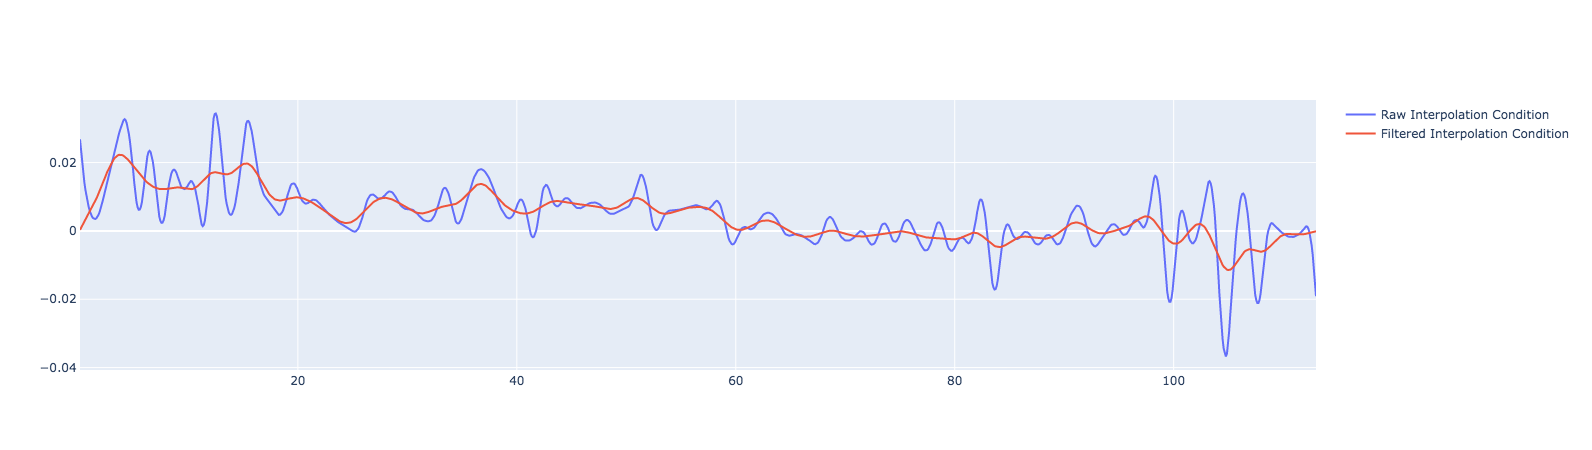

In [9]:
fig = go.Figure()

y1 = np.diff(f_t(time_sim)) / f_t(time_sim[1:]) 
y2 = np.diff(ff_t(time_sim)) / ff_t(time_sim[1:]) 

fig.add_trace(go.Scatter(
    name="Raw Interpolation Condition",
    x=time_sim[1:],
    y=y1))

fig.add_trace(go.Scatter(
    name="Filtered Interpolation Condition",
    x=time_sim[1:],
    y=y2))

### 3 - Determining the function $p(t) = \frac{f''(t)f(t)-f'^2(t)}{f(t)(f'(t)+rf(t))}$

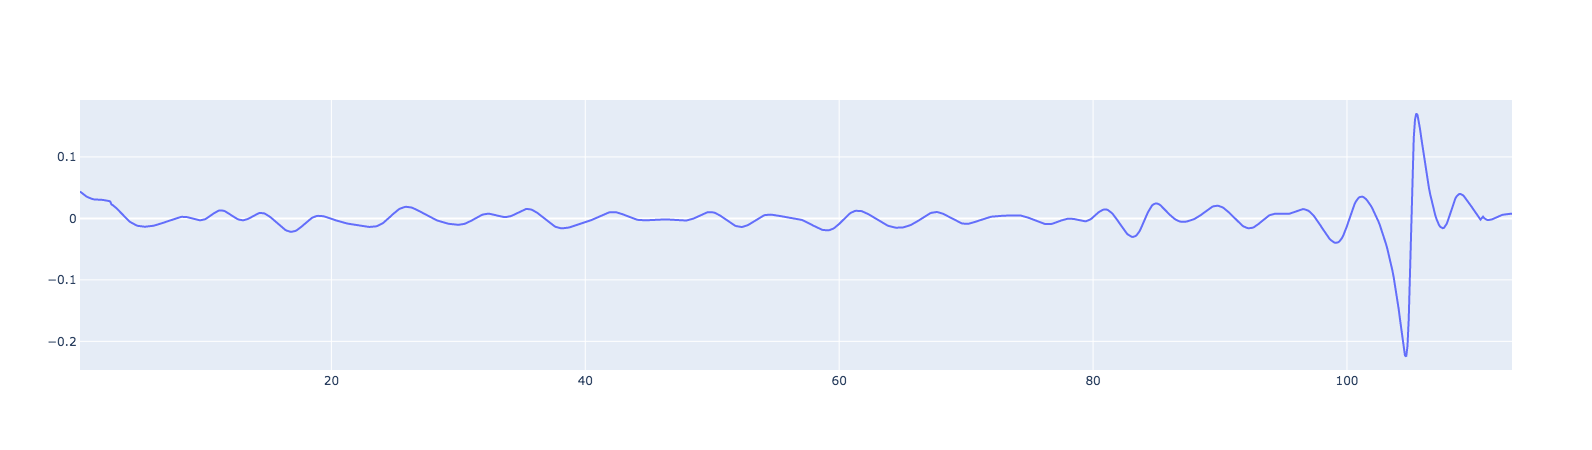

In [10]:
# Defining the r
r = abs(1.1 * min(y2))

# Computing p(t)
f = ff_t(time_sim)
df = np.diff(f)
ddf = np.diff(df)

# Correcting sizes
df, f = df[1:], f[2:]

p = (ddf*f - df**2) / (f*(df + r*f))

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Value of $p(t)$",
    x=time_sim[2:],
    y=p))
fig.show()

### 4 - Choosing the value of $\beta(0)$ and defining the value of $P(t) = \int_0^t p(\tau) d\tau$

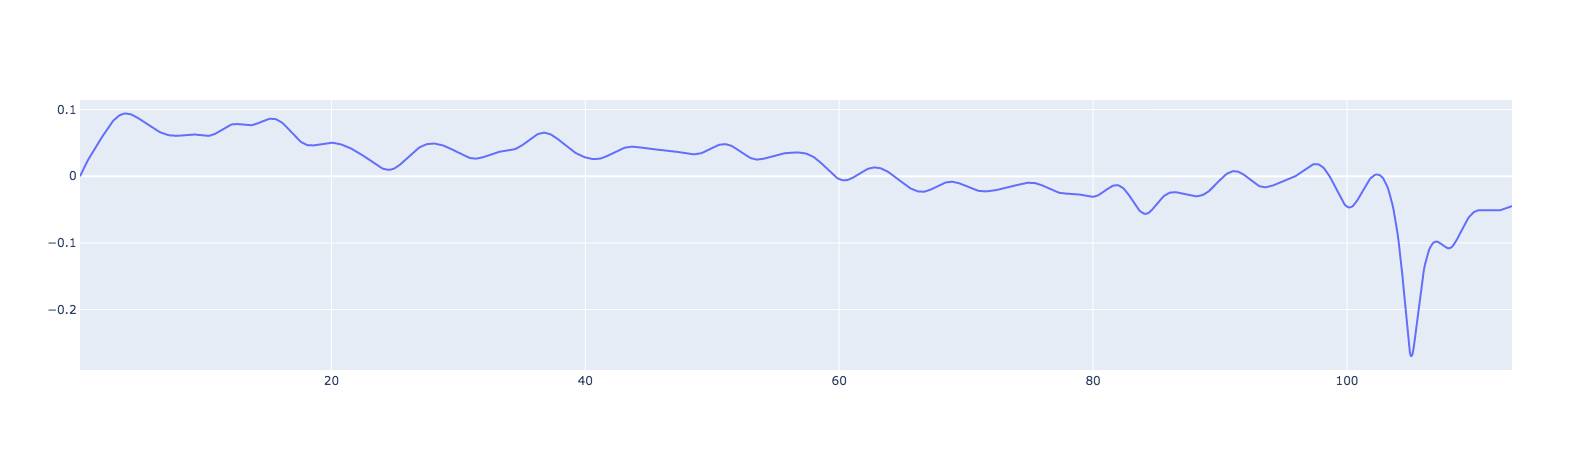

In [11]:
from scipy import integrate

P = integrate.cumtrapz(p, time_sim[2:], initial=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Value of P(t)",
    x=time_sim[2:],
    y=P))
fig.show()

### 5 - Verifing the values that respect: $\beta(0) <\frac{1}{\int_0^t e^{P(s)}f(s) ds}$

/Users/marcelolima/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide



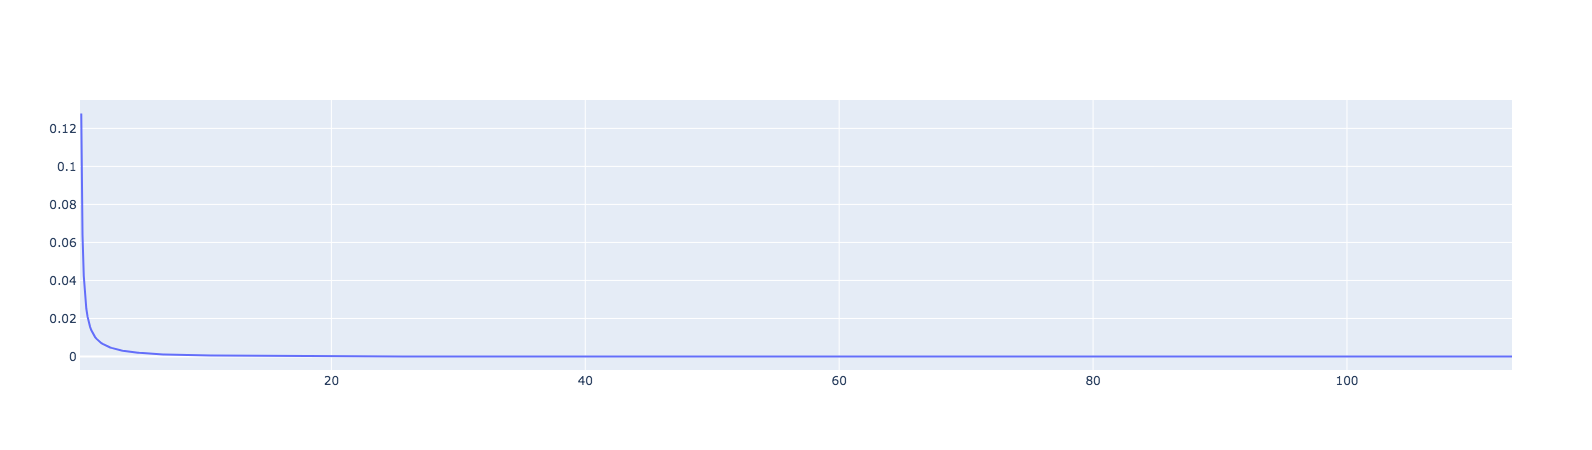

In [12]:

int_content = np.exp(P) * f
condition = 1 / integrate.cumtrapz(int_content, time_sim[2:], initial=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Initial condition for Beta",
    x=time_sim[2:],
    y=condition))
fig.show()

### 6 - Compute the parameter $\mathbf{\beta(t)}$ pode ser calculado por: $\beta(t) = \frac{1}{\frac{e^{-P(t)}}{\beta(0)}-e^{-P(t)}\int_0^t e^{P(s)}f(s) ds}$

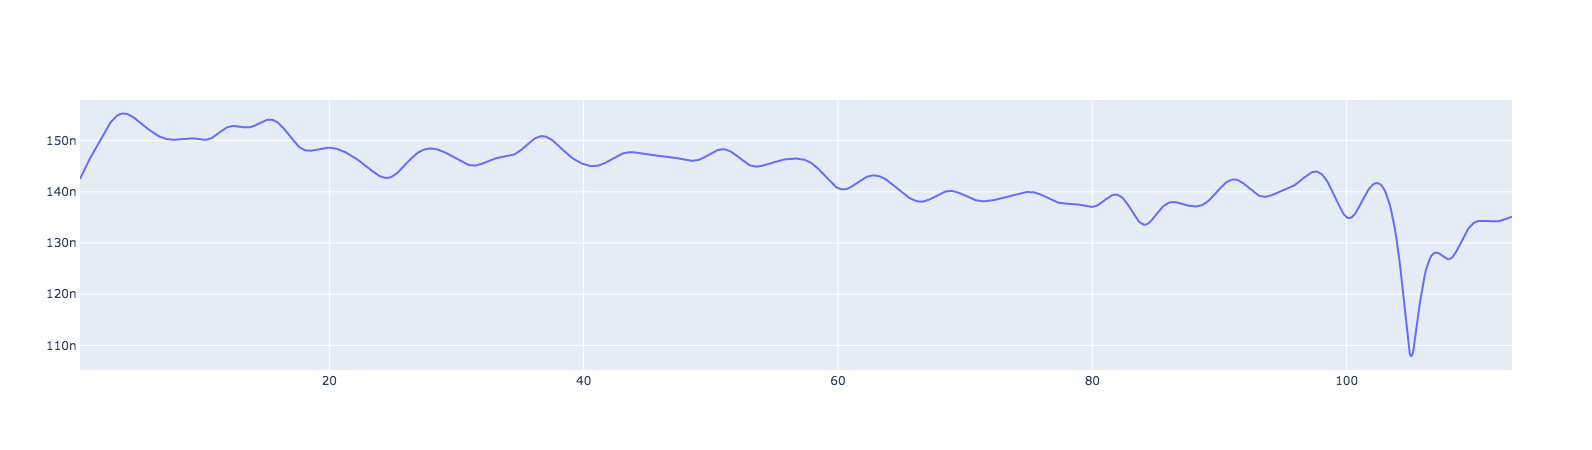

In [13]:
beta_0 = np.divide(1, pop)
beta_t = 1 / ((np.exp(-P)/ beta_0) - np.exp(-P) * condition)

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Beta(t)",
    x=time_sim[4:],
    y=beta_t[2:]))
fig.show()

## Estimating the state parameters

In [14]:
from models import *

dataset = dict(S=S, I=I, R=R, D=D)

model = ss.SIR(pop=pop, focus=["S","I","R","D"])

model.fit(dataset, time,  
          search_pop=True,
          pop_sens=[0.00001, 0.05],
          Ro_sens=[0.8, 15], 
          D_sens=[5, 60],
          mu_sens=[0.0001, 0.02])


Loading BokehJS ...

	 ├─ initial conditions ─  [7075098.0, 70.0, 12.0, 1.0]
	 ├─ Ro bound ─  0.8  ─  15
	 ├─ D  bound ─  5  ─  60
	 ├─ equation weights ─  [1.4214975419994448e-07, 7.905237011487557e-05, 3.755335293794045e-05, 0.000936468036867268]
	 ├─ Running on ─  differential_evolution SciPy Search Algorithm
	 └─ Defined at:  2.5971567764096357  ─  14.93385715685735 



In [15]:
print("Parâmetros estimados: ", model.parameters)
print("Suposto Ro: ", model.parameters[0])
print("Valores de beta: {}, e r: {}".format(
    model.parameters[0]/model.parameters[1], 1/model.parameters[1]))
print("Dias contaminados: ", model.parameters[1])

Parâmetros estimados:  [2.59715678e+00 1.49338572e+01 2.22761094e-03 1.63884444e-02]
Suposto Ro:  2.5971567764096357
Valores de beta: 0.17391064807507345, e r: 0.06696193685907988
Dias contaminados:  14.93385715685735


# Analysing $R(t)$
---

## Estimating the $R(t)$ from $\beta(t)$

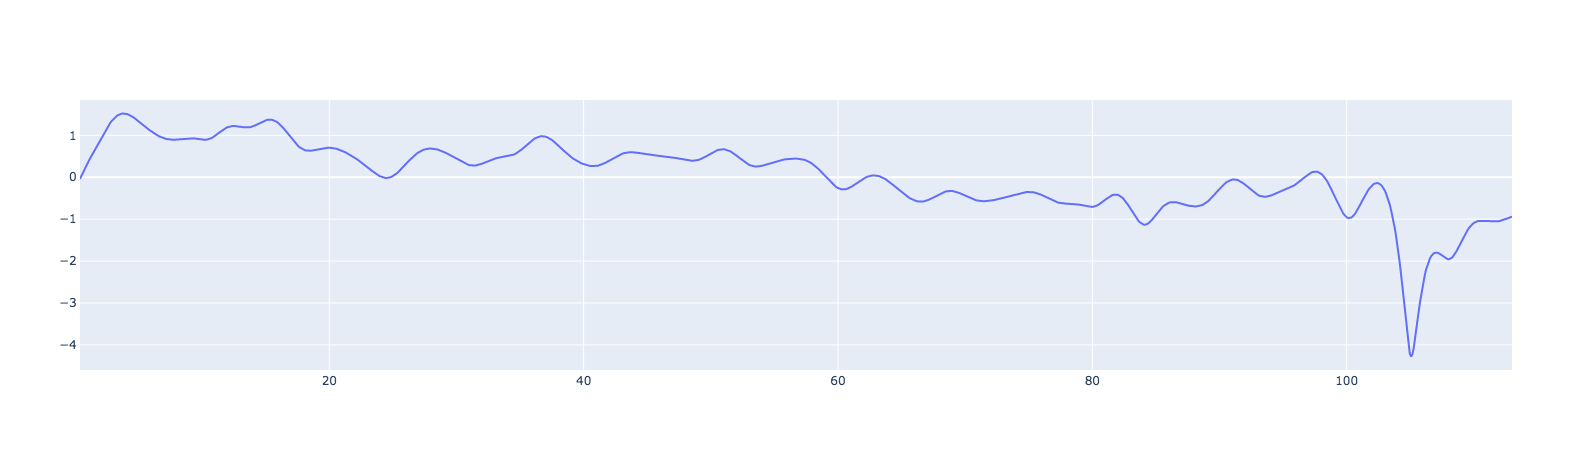

In [16]:
gamma = 1 / model.parameters[1]
mu    = model.parameters[2]
sigma = model.parameters[-1]

beta_bar_t = beta_t * pop

# Computing R(t)
R_t = pop * sigma * beta_t / (gamma + mu)

# Normalizing R(t)
R_t_norm = (R_t - np.mean(R_t)) / np.std(R_t)

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="R(t) - Time variant",
    x=time_sim[4:],
    y=R_t_norm[2:]))
fig.show()

## Estimating $R(t)$ from the model

In [ ]:

from tqdm import tqdm
from models import *

parameters = dict(R=[], D=[], mu=[], sigma=[], time=[])

for i in tqdm(range(10, len(I), 2)):
    
    dataset = dict(S=S[:i], I=I[:i], R=R[:i], D=D[:i])
    
    model = ss.SIR(pop=pop, focus=["S","I","R","D"], verbose=False)
    
    model.fit(dataset, time[:i],  
              search_pop=True,
              pop_sens=[0.00001, 0.05],
              Ro_sens=[0.8, 15], 
              D_sens=[5, 60],
              mu_sens=[0.0001, 0.02])
    
    for k, par in enumerate(["R", "D", "mu", "sigma"]):
        parameters[par].append(model.parameters[k])
    parameters["time"].append(i)

  6%|▌         | 3/52 [00:35<08:49, 10.81s/it]/Users/marcelolima/Projects/epidemicModels/models/discrete_models.py:99: RuntimeWarning:

overflow encountered in longdouble_scalars

/Users/marcelolima/Projects/epidemicModels/models/discrete_models.py:100: RuntimeWarning:

overflow encountered in longdouble_scalars

/Users/marcelolima/Projects/epidemicModels/models/cost_functions.py:160: RuntimeWarning:

overflow encountered in square

 75%|███████▌  | 39/52 [16:43<08:44, 40.36s/it]

In [ ]:
# Normalizing the model based R(t)
R_t_par_norm = (parameters["R"] - np.mean(parameters["R"])) / np.std(parameters["R"])

fig.add_trace(go.Scatter(
    name="R(t) - Model",
    x=parameters["time"],
    y=R_t_par_norm))

fig.update_layout(title="R(t) comparison")
fig.show()

In [ ]:
# Normalizing the model based Beta(t)
beta_t_par = np.array(parameters["R"]) / np.array(parameters["D"])
beta_t_par_norm = (beta_t_par - np.mean(beta_t_par)) / np.std(beta_t_par)

# Normalizing the Beta(t)
beta_t_norm = (beta_t - np.mean(beta_t)) / np.std(beta_t)

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Beta(t) - Time variant",
    x=time_sim[4:],
    y=beta_t_norm[2:]))
fig.add_trace(go.Scatter(
    name="Beta(t) - Model",
    x=parameters["time"],
    y=beta_t_par_norm))
fig.update_layout(title="Comparing the beta(t) estimates")
fig.show()

## Estimating the $R(t)$ from the dataset

In [ ]:
import numpy as np

window_size = 5  # Tamanho da janela de estimação em dias

Likeli = list()
R_t_data, date_data = list(), list()
for k in range(0, len(I) - window_size):
    next_k = k + window_size
    C_now  = I[k]
    C_next = I[next_k]
    at_time = time[k]
    R_t_data.append(C_next / C_now)
    date_data.append(at_time)
R_t_data = np.array(R_t_data)
date_data = np.array(date_data)

### Predict the components

In [ ]:
initial = (S[0], I[0], R[0], D[0])
tsim = np.linspace(0, len(I)-1, len(I))
# time_ref_sim = [date[0] + timedelta(days=i) for i in tsim]

sim_res = model.predict(initial, tsim)

In [ ]:
R_t_model, date_model = list(), list()
for k in range(0, len(sim_res[1]) - window_size):
    next_k = k + window_size
    C_now  = sim_res[1][k]
    C_next = sim_res[1][next_k]
    at_time = tsim[k]
    R_t_model.append(C_next / C_now)
    date_model.append(at_time)
R_t_model = np.array(R_t_model)
date_model = np.array(date_model)

In [ ]:
# Normalizing both approaches
R_t_data_norm = (R_t_data - np.mean(R_t_data)) / np.std(R_t_data)
R_t_model_norm = (R_t_model - np.mean(R_t_model)) / np.std(R_t_model)

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("R(t) comparison", "Infected data"))
fig.add_trace(go.Scatter(
    name="R(t) - Time variant",
    x=time_sim[4:],
    y=R_t_norm[2:]),
    row=1, col=1)
fig.add_trace(go.Scatter(
    name="R(t) - Model Parameters",
    x=parameters["time"],
    y=R_t_par_norm),
    row=1, col=1)
fig.add_trace(go.Scatter(
    name="R(t) - Raw Data",
    x=date_data,
    y=R_t_data_norm),
    row=1, col=1)
fig.add_trace(go.Scatter(
    name="R(t) - Model Prediction",
    x=date_model,
    y=R_t_model_norm),
    row=1, col=1)

fig.update_layout(height=800)

fig.add_trace(go.Scatter(
    name="Infected data",
    x=time, y=I),
    row=2, col=1)
fig.show(height=800)

### Compute the $R^2$ for the comparisons

# Generating the comparison for all states
---

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

JSON_KEY_PATH = './app/gkeys/epidemicapp-62d0d471b86f.json'
CREDENTIALS = service_account.Credentials.from_service_account_file(JSON_KEY_PATH)

client = bigquery.Client(project="epidemicapp-280600", credentials=CREDENTIALS)

query = """select * from states.last_parameters"""

pars_df = client.query(query, 
                       job_config=bigquery.QueryJobConfig()
                      ).to_dataframe()
pars_df.head()

In [ ]:
import numpy as np
from datetime import timedelta

from models import *
from models.preprocessing import basic_reproduction_number

R_struc = dict()
for state in wlcota_df["state"].where(wlcota_df["state"] != "TOTAL").dropna().unique():
    print(f"  -> Running state {state}...")
    
    # Getting the state dataframe
    state_df = wlcota_df.where(wlcota_df["state"]==state).dropna()
    
    if len(state_df) > 5 and state in pars_df["state"].unique():
        
        # Make date column datetime objects
        state_df["date"] = [datetime.fromisoformat(d) for d in state_df["date"].values]
        state_pars_df = pars_df.where(pars_df["state"] == state).dropna()
        
        # Resample non existing data
        first_date = state_df['date'].iloc[0]
        size_days = (state_df['date'].iloc[-1] - state_df['date'].iloc[0]).days
        date_vec = [first_date + timedelta(days=k) for k in range(size_days)]
        new_df = pd.DataFrame(date_vec, columns=['date'])
        new_df = pd.merge(new_df, state_df, how='left', on='date')
        state_df  = new_df.fillna(method='ffill')

        # State population
        pop = state_pop[state]["population"]

        # Determining the deads component
        D = state_df["deaths"].values
        # Determining the recovered component
        R = state_df["recovered"].values
        # Determining the infected component
        C = state_df["totalCases"].values
        I = [C[0]]
        for nc, nd, nr in zip(np.diff(C), np.diff(D), np.diff(R)):
            I += [ I[-1] + nc - nr - nd ]
        # Determining the susceptible component
        S = pop - R - D - I

        # Compute the state model
        dataset = dict(S=S, I=I, R=R, D=D)
        model = ss.SIR(pop=pop, 
                       focus=["S","I","R","D"], 
                       verbose=False,
                       forced_search_pop=True)
        model.parameters = state_pars_df.iloc[0,:-1].tolist()

        # Create the state content
        R_struc[state] = dict()

        # Generate the values for R(t)
        I = np.array(I)
        R_t_data, time_data = basic_reproduction_number(using=I, mode="raw")
        R_t_time_variant, time_time_variant = basic_reproduction_number(using=I, mode="time variant", population=pop)
        R_t_model, time_model= basic_reproduction_number(using=model, mode="model", z_score=True,
                                                              population=pop, initial=(S[0], I[0], R[0], D[0]), time=np.linspace(0, len(I)-1, len(I)))

        R_struc[state]["content"] = dict(val=I, time=np.linspace(0, len(I)-1, len(I)))
        R_struc[state]["data"]  = dict(val=R_t_data, time=time_data)
        R_struc[state]["tvar"]  = dict(val=R_t_time_variant, time=time_time_variant)
        R_struc[state]["model"] = dict(val=R_t_model, time=time_model)


In [ ]:
from plotly.subplots import make_subplots

state = "MA"

time_data = R_struc[state]["data"]["time"]
R_t_data = R_struc[state]["data"]["val"]
time_tvar = R_struc[state]["tvar"]["time"]
R_t_tvar = R_struc[state]["tvar"]["val"]
time_model = R_struc[state]["model"]["time"]
R_t_model = R_struc[state]["model"]["val"]


fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Data based",
    x=time_data, 
    y=R_t_data,
    mode="lines+markers",
    marker_size=5,
    line=dict(width=2, dash="dot", color="black")))
fig.add_trace(go.Scatter(
    name="Time variant",
    x=time_tvar, 
    y=R_t_tvar,
    line=dict(width=2,color="grey")))
fig.add_trace(go.Scatter(
    name="Prediction based",
    x=time_model, 
    y=R_t_model,
    line=dict(color="red", width=2.5)))

fig.update_layout(
    autosize=False,
    template='presentation',
    font=dict(
        family="Sans Serif, bold",
        size=25,
        color="black"
    ),
    margin=dict(
        l=60,
        r=40,
        b=80,
        t=0,
        pad=0
    ),
    legend=dict(
        x=0.75,
        y=1,
        font=dict(
            size=21,
        ),
    )
)
fig.update_xaxes(title_text='Time (days)')
# fig.update_yaxes(title_text='Value A')
fig.show(height=500, width=800)
fig.write_image("./Maranhao_R_t.eps")



#fig.update_layout(title=f"R(t) estimates for state {state} - z Score", height=700)
# fig.show()

In [ ]:
corr = np.correlate(R_struc["SP"]["data"]["val"][51:], R_struc["TO"]["data"]["val"], mode="full")
ctime = np.linspace(-(len(corr)-1)//2, (len(corr)-1)//2, len(corr))

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Correlation",
    x=ctime,
    y=corr))
fig.show()

In [ ]:
ctime[corr.tolist().index(max(corr))]

In [ ]:
to_date = wlcota_df.where(wlcota_df["state"] == "TO").dropna()["date"].min()
sp_date = wlcota_df.where(wlcota_df["state"] == "SP").dropna()["date"].min()

from datetime import datetime

sp_date, to_date = datetime.fromisoformat(sp_date), datetime.fromisoformat(to_date)
(sp_date - to_date).days

In [ ]:
fig = go.Figure()

shift = 51
y_1 = (R_struc["SP"]["content"]["val"][shift:] - np.mean(R_struc["SP"]["content"]["val"][shift:])) / np.std(R_struc["SP"]["content"]["val"][shift:])
y_2 = (R_struc["TO"]["content"]["val"] - np.mean(R_struc["TO"]["content"]["val"])) / np.std(R_struc["TO"]["content"]["val"])

fig.add_trace(go.Scatter(
    x=R_struc["SP"]["content"]["time"][:-shift],
    y=y_1,
))
fig.add_trace(go.Scatter(
    x=R_struc["TO"]["content"]["time"],
    y=y_2,
))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.linspace(0, len(R_struc["SP"]["data"]["val"])-1, len(R_struc["SP"]["data"]["val"])),
    y=R_struc["SP"]["data"]["val"],
))
fig.add_trace(go.Scatter(
    x=np.linspace(0, len(R_struc["TO"]["data"]["val"])-1, len(R_struc["TO"]["data"]["val"])),
    y=R_struc["TO"]["data"]["val"]
))
fig.show()

# Comparing the $R(t)$ of different states
---

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance, mean_gamma_deviance
import scipy.stats as ss
import scipy.spatial.distance as ssd 

comparison = lambda x, y: ss.pearsonr(x, y)[0] #ss.kendalltau(x,y)[0] #ss.spearmanr(x, y) #np.corrcoef(x,y)[0,1]**2

comp_ind = ["E{Model, Data}","E{Model, Time Variant}","E{Data, Time Variant}"]
R_comp = dict()

for state in R_struc.keys():
    
    if state not in ["SC", "SE", "TO"]:
        model_vals = R_struc[state]["model"]["val"]
        data_vals = R_struc[state]["data"]["val"]
        tvar_vals = R_struc[state]["tvar"]["val"]

        r_size = min([len(x) for x in [model_vals, data_vals, tvar_vals]])
        model_vals = model_vals[:r_size]
        data_vals  = data_vals[:r_size]
        tvar_vals  = tvar_vals[:r_size]

        try:
            R_comp[state] = []
            R_comp[state].append( comparison(data_vals, model_vals) )
            R_comp[state].append( comparison(model_vals, tvar_vals) )
            R_comp[state].append( comparison(data_vals, tvar_vals) )
        except Exception as e:
            print(f"Error at {state} as {e}")
            R_comp[state] = [0, 0, 0]
R_squared_df = pd.DataFrame(R_comp)
R_squared_df.index = comp_ind
R_squared_df.head()

# Creating the time visualization of $R(t)$
---

In [ ]:
mode = "model"

init = datetime.fromisoformat(wlcota_df["date"].min())
final = datetime.fromisoformat(wlcota_df["date"].max())
dates = [init + timedelta(k) for k in range((final-init).days)]
R_state_df = pd.DataFrame(columns=["date", "R_t", "state"])

for state in R_struc.keys():
    
    initial_date = wlcota_df.where(wlcota_df["state"] == state).dropna()["date"].min()
    initial_date = datetime.fromisoformat(initial_date)
    
    r_size = len(R_struc[state][mode]["val"])
    dates = [initial_date + timedelta(days=k) for k in range(r_size)]
    states = [state] * len(dates)
    
    new_df = pd.DataFrame({"date":dates, "R_t":R_struc[state][mode]["val"], "state":states})
    R_state_df = pd.concat((R_state_df, new_df), axis=0)
    

In [ ]:
fig = go.Figure()
for state in R_state_df["state"].unique():
    state_df = R_state_df.where(R_state_df["state"] == state).dropna()
    fig.add_trace(go.Scatter(
        name=state,
        x=state_df["date"],
        y=state_df["R_t"]
    ))
fig.show()

In [ ]:
R_state_df = R_state_df[R_state_df['state'] != "SE"]
R_state_df = R_state_df[R_state_df['state'] != "TO"]
R_state_df = R_state_df[R_state_df['state'] != "SC"]

## Getting the first $R(t)$ of each state to create pondering

In [ ]:
# from sklearn.preprocessing import StandardScaler

# R_0 = list()
# for state in R_state_df["state"].unique():
#     state_df = R_state_df.where(R_state_df["state"] == state).dropna()
#     R_0.append( state_df["R_t"].where(state_df["date"] == state_df["date"].min()).dropna().iloc[0] )
# R_0 = np.array(R_0)
# R_0 = R_0[np.where(abs(R_0) < 4)]
# R_0 = max(R_0)

# R_state_df = R_state_df.where(R_state_df["R_t"] < 5).dropna()

# sup_df = pd.DataFrame(columns=["date", "R_t", "state"])
# for state in R_state_df["state"].unique():
#     state_df = R_state_df.where(R_state_df["state"] == state).dropna()
#     initial_R = state_df["R_t"].where(state_df["date"] == state_df["date"].min()).dropna().iloc[0]
#     state_df["R_t"] = state_df["R_t"] + (initial_R - R_0)
#     sup_df = pd.concat((sup_df, state_df), axis=0)
# R_state_df = sup_df


max_value, min_value = 1.8, 0.2 

# for state in R_state_df["state"].unique():

#     indexes = R_state_df["state"] == state
#     R_vals = R_state_df["R_t"][indexes].dropna()
#     R_state_df["R_t"][indexes] = (R_state_df["R_t"][indexes] - min_value) / (max_value - min_value)
    
    
# R_state_df["R_t"] = (R_state_df["R_t"] - R_state_df["R_t"].mean()) / R_state_df["R_t"].std()

In [ ]:
R_state_df

In [ ]:
import plotly.express as px
import json

with open('./kaggle_content/brasil_estados.geojson') as handle:
    states_geo = json.load(handle)

colorscale = ["#E2AAF3","#E2AAF3","#E889ED","#E569D4","#DE4AAE",
    "#D52C7F", "#CB0F48", "#A80A18", "#841505", "#5F2102", "#381F01", "#0A2F51",
    "#0E4D64", "#137177", "#188977", "#1D9A6C", "#39A96B", "#56B870", "#74C67A",
    "#99D492", "#BFE1B0", "#DEEDCF"]
endpts = list(np.linspace(min_value, max_value, len(colorscale) - 1))
    
number_day_periods = 16
day_period = (R_state_df["date"].max() - R_state_df["date"].min()).days // number_day_periods

for period_num in range(number_day_periods):
    
    pars_df = R_state_df.where(R_state_df["date"] <= R_state_df["date"].min() + (period_num+1) * timedelta(days=day_period)).dropna()
    pars_df = pars_df.where(pars_df["date"] > pars_df["date"].min() + period_num * timedelta(days=day_period)).dropna()
    current_time = pars_df["date"].min()
    pars_df = pars_df.groupby(by="state").mean().reset_index()
    
    fig = go.Figure()
    fig.add_trace(go.Choropleth(geojson=states_geo,
                              locations=pars_df["state"], 
                              z=pars_df["R_t"],
                              colorscale=colorscale[::-1],
                              zmin=min_value, zmax=max_value,
                              marker_opacity=0.5, 
                              marker_line_width=0, 
                              featureidkey="properties.uf_05"))

    fig.update_layout(
        margin={"r":0,"l":0,"b":0, "t":50}, 
        title={
            'text': f"At: {current_time.strftime('%d/%m/%Y')}",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font_family': "roman serif"
        },
        width=500
        )
    fig.update_traces(showscale=False)
    fig.update_geos(fitbounds="locations", visible=True,
                    showcountries=True, countrycolor="Grey")
    fig.write_image(f"./paper_results/week_{period_num}_heatmap.png", width=700)
#     fig.show()

In [ ]:
R_state_df

In [ ]:
fig.write_image(f"./paper_results/week_{period_num}_heatmap.png", width=700)

# Comparing the $R(t)$ from different states
---

In [ ]:

mode = "data"
R_2_struc = dict()

for i in R_struc.keys():
    R_2_struc[i] = []
    for j in R_struc.keys():
        
        first_state = R_struc[i][mode]["val"]
        second_state = R_struc[j][mode]["val"]
        
        # Check the correlation drift
        corr = np.correlate(first_state, second_state, mode="full")
        ctime = np.linspace(-(len(corr)-1)//2, (len(corr)-1)//2, len(corr))
        time_shift = int(ctime[corr.tolist().index(max(corr))])
        
        # Shift the R(t) values
        if time_shift >= 0:
            first_state = first_state[time_shift:]
        else:
            second_state = second_state[abs(time_shift):]
        
        # Compute the size of the comparison vectors
        r_size = min([len(first_state), len(second_state)])
        first_state = first_state[:r_size]
        second_state = second_state[:r_size]
        
        # Check size of both Rˆ2
        SSE = sum((first_state - second_state)**2)
        SST = sum((first_state - np.mean(first_state))**2)
        
        if i != j:
            R_2 = 1 - (SSE / SST)
        else: 
            R_2 = 1.0
        
        R_2_struc[i].append(R_2)

R_2_df = pd.DataFrame(R_2_struc)
R_2_df.index = R_struc.keys()

In [ ]:
first_state = R_struc[i][mode]["val"]
second_state = R_struc[j][mode]["val"]

In [ ]:
time_shift

In [ ]:
second_state